In [1]:
# ==== Imports & config ====
import os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.metrics import mean_squared_error
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# ==== Cấu hình bài toán ====
GRID = 5                                  # 5x5 cảm biến
FEATURES = ["dust", "temp", "humidity", "MQ2", "MQ7"]
TIME_STEPS = 3                            # số bước quá khứ để dự đoán bước kế
FUTURE_STEPS = 1                          # dự đoán 1 bước trước
BATCH_SIZE = 16
EPOCHS = 60
MODEL_PATH = "best_cnn_lstm.keras"
ERROR_THRESHOLD = 0.10                    # ngưỡng RMSE để dừng dự đoán liên tục (trên dữ liệu đã scale)
SCALER_TYPE = "minmax"                    # "minmax" hoặc "l2"

np.random.seed(1337)


In [2]:
# ==== Đọc dữ liệu ====
# Đảm bảo file "sensor_data.csv" có cột: time,x,y,dust,temp,humidity,MQ2,MQ7
df = pd.read_csv("02_data_clean.csv")
df["time"] = pd.to_datetime(df["time"])

# ==== Sắp xếp & nội suy / điền thiếu ====
df.sort_values(["time", "x", "y"], inplace=True)
df.interpolate(method="linear", inplace=True)

num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

# ==== Giữ các timestamp đủ 25 ô (5x5) ====
counts = df["time"].value_counts()
valid_times = counts[counts == GRID*GRID].index
df = df[df["time"].isin(valid_times)].copy()
df.sort_values(["time", "x", "y"], inplace=True)

print("Số timestamp hợp lệ:", df["time"].nunique())
df.head()


Số timestamp hợp lệ: 30228


,time,x,y,dust,temp,humidity,MQ2,MQ7
0,2025-08-09 12:53:41+07:00,1,1,4.016403,26.776457,71.315604,499.373452,644.667206
1,2025-08-09 12:53:41+07:00,1,2,4.016403,26.776457,71.315604,499.373452,644.667206
2,2025-08-09 12:53:41+07:00,1,3,4.016403,26.776457,71.315604,499.373452,644.667206
3,2025-08-09 12:53:41+07:00,1,4,0.000000,24.900000,60.000000,687.000000,435.200000
4,2025-08-09 12:53:41+07:00,1,5,4.016403,26.776457,71.315604,499.373452,644.667206


In [3]:
# Hai lựa chọn:
# - "minmax": giữ tương quan biên độ (thường tốt cho CNN/LSTM time-series)
# - "l2": Normalizer theo từng hàng (vector 5 feature của một ô) giống code mẫu cổ điển 1D
if SCALER_TYPE.lower() == "minmax":
    scaler = MinMaxScaler()
    df[FEATURES] = scaler.fit_transform(df[FEATURES])
elif SCALER_TYPE.lower() == "l2":
    scaler = Normalizer()  # L2 theo hàng
    # normalizer áp theo từng hàng (mỗi record là 1 ô cảm biến)
    df[FEATURES] = scaler.fit_transform(df[FEATURES].values)
else:
    raise ValueError("SCALER_TYPE phải là 'minmax' hoặc 'l2'.")

print(df[FEATURES].describe().T)


             count      mean       std  min       25%       50%       75%  max
dust      755700.0  0.030808  0.036001  0.0  0.030808  0.030808  0.030808  1.0
temp      755700.0  0.589434  0.088475  0.0  0.589434  0.589434  0.589434  1.0
humidity  755700.0  0.637589  0.103187  0.0  0.637589  0.637589  0.637589  1.0
MQ2       755700.0  0.371006  0.126420  0.0  0.371006  0.371006  0.371006  1.0
MQ7       755700.0  0.344135  0.102529  0.0  0.344135  0.344135  0.344135  1.0


In [4]:
X_list, y_list, t_targets = [], [], []
times_sorted = sorted(df["time"].unique())

for i in range(len(times_sorted) - TIME_STEPS - FUTURE_STEPS + 1):
    past_times = times_sorted[i:i+TIME_STEPS]
    future_time = times_sorted[i+TIME_STEPS]  # t+1

    # X: stack các snapshot quá khứ
    X_block = []
    ok = True
    for t in past_times:
        snap = df[df["time"] == t].sort_values(["x", "y"])[FEATURES].values
        if snap.shape[0] != GRID*GRID:
            ok = False
            break
        snap = snap.reshape(GRID, GRID, len(FEATURES))
        X_block.append(snap)
    if not ok:
        continue

    # y: snapshot của future_time (flatten)
    y_snap = df[df["time"] == future_time].sort_values(["x", "y"])[FEATURES].values
    if y_snap.shape[0] != GRID*GRID:
        continue
    y_vec = y_snap.flatten()

    X_list.append(np.array(X_block))
    y_list.append(y_vec)
    t_targets.append(future_time)

X = np.array(X_list)  # (samples, TIME_STEPS, GRID, GRID, num_features)
y = np.array(y_list)  # (samples, GRID*GRID*num_features)
t_targets = np.array(t_targets)

print("X shape:", X.shape, "y shape:", y.shape, "num target times:", len(t_targets))
assert X.ndim == 5 and y.ndim == 2


X shape: (30225, 3, 5, 5, 5) y shape: (30225, 125) num target times: 30225


In [5]:
n = len(X)
train_end = int(0.7*n)
val_end   = int(0.85*n)

X_train, y_train = X[:train_end], y[:train_end]
X_val,   y_val   = X[train_end:val_end], y[train_end:val_end]
X_test,  y_test  = X[val_end:], y[val_end:]
times_test = t_targets[val_end:]

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape,   y_val.shape)
print("Test: ", X_test.shape,  y_test.shape)


Train: (21157, 3, 5, 5, 5) (21157, 125)
Val:   (4534, 3, 5, 5, 5) (4534, 125)
Test:  (4534, 3, 5, 5, 5) (4534, 125)


In [6]:
model = Sequential([
    Input(shape=(TIME_STEPS, GRID, GRID, len(FEATURES))),
    TimeDistributed(Conv2D(32, (3,3), activation='relu', padding="same")),
    TimeDistributed(MaxPooling2D((2,2))),
    TimeDistributed(Flatten()),
    LSTM(64, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(GRID*GRID*len(FEATURES))  # hồi quy đa đầu ra
])

model.compile(optimizer="adam", loss="mse")
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 3, 5, 5, 32)    │         1,472 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 3, 2, 2, 32)    │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 3, 128)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 125)            │         8,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,005 (230.49 KB)

 Trainable params: 59,005 (230.49 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
1311/1323 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0168
Epoch 1: val_loss improved from inf to 0.00935, saving model to best_cnn_lstm.keras
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0167 - val_loss: 0.0093 - learning_rate: 0.0010
Epoch 2/60
1314/1323 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016
Epoch 2: val_loss improved from 0.00935 to 0.00859, saving model to best_cnn_lstm.keras
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0016 - val_loss: 0.0086 - learning_rate: 0.0010
Epoch 3/60
1306/1323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.6034e-04
Epoch 3: val_loss improved from 0.00859 to 0.00841, saving model to best_cnn_lstm.keras
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 8.5900e-04 - val_loss: 0.0084 - learning_rate: 0.0010
Epoch 4/60
1315/1323 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1264e-04
Epoch 4: val_loss did not improve from 0.00841
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 5.1228e-04 - val_loss: 0.0086 - learning_rate: 0.00

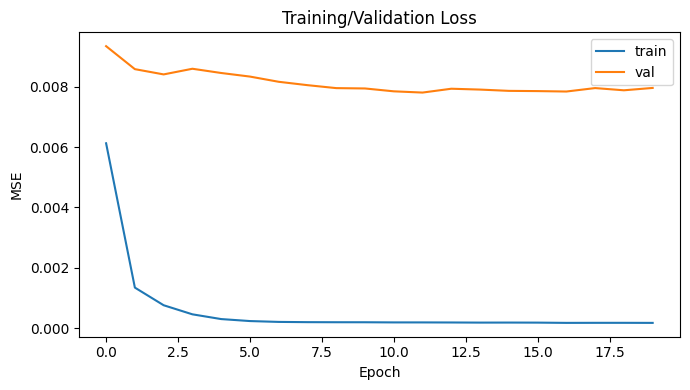

In [7]:
os.makedirs("logs/cnn_lstm", exist_ok=True)

cbs = [
    EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6, verbose=1),
    ModelCheckpoint(MODEL_PATH, monitor="val_loss", save_best_only=True, verbose=1)
]

hist = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=cbs,
    verbose=1
)

plt.figure(figsize=(7,4))
plt.plot(hist.history["loss"], label="train")
plt.plot(hist.history["val_loss"], label="val")
plt.title("Training/Validation Loss")
plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.legend(); plt.tight_layout(); plt.show()


In [8]:
# Dự đoán test
y_pred_test = model.predict(X_test, verbose=0)

rmse_total = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"Test RMSE (tổng): {rmse_total:.6f} (đơn vị đang ở không gian đã chuẩn hoá)")

# RMSE theo feature (trên không gian đã scale)
F = len(FEATURES); HW = GRID*GRID
for fi, fname in enumerate(FEATURES):
    y_true_f = y_test[:, fi:HW*F:F]     # lấy đúng vị trí cột của feature đó
    y_pred_f = y_pred_test[:, fi:HW*F:F]
    rmse_f = np.sqrt(mean_squared_error(y_true_f, y_pred_f))
    print(f"  - {fname}: RMSE = {rmse_f:.6f}")


Test RMSE (tổng): 0.104329 (đơn vị đang ở không gian đã chuẩn hoá)
  - dust: RMSE = 0.050535
  - temp: RMSE = 0.094422
  - humidity: RMSE = 0.104540
  - MQ2: RMSE = 0.154544
  - MQ7: RMSE = 0.090224


In [9]:
# Load best model (đảm bảo dùng model tốt nhất)
from tensorflow.keras.models import load_model
best_model = load_model(MODEL_PATH)

threshold = ERROR_THRESHOLD  # trên dữ liệu đã scale/normalize
continuous_preds = []
prediction_times = []

current_input = X_test[0:1] # (1, TIME_STEPS, 5,5, F)
idx = 0

for step in range(200):  # giới hạn an toàn
    y_pred = best_model.predict(current_input, verbose=0)  # (1, 125)
    y_pred_flat = y_pred.flatten()
    continuous_preds.append(y_pred_flat)

    # thời điểm tương ứng của bước dự đoán hiện tại
    t_idx = min(idx, len(times_test)-1)
    prediction_times.append(times_test[t_idx])

    # Nếu còn ground truth để đánh giá
    if idx < len(y_test):
        y_true_flat = y_test[idx].flatten()
        rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
        print(f"Step {step+1} | RMSE={rmse:.6f}")
        if rmse > threshold:
            print(f"Stop early at step {step+1} (RMSE={rmse:.6f} > {threshold})")
            break

    # Trượt cửa sổ thời gian: bỏ frame đầu, thêm frame dự đoán mới
    new_snapshot = y_pred_flat.reshape(GRID, GRID, len(FEATURES))      # (5,5,F)
    new_snapshot = new_snapshot[np.newaxis, np.newaxis, ...]           # (1,1,5,5,F)
    current_input = np.concatenate([current_input[:, 1:], new_snapshot], axis=1)
    idx += 1

continuous_preds = np.array(continuous_preds)  # (steps, 125)
print("Total steps predicted:", continuous_preds.shape[0])


Step 1 | RMSE=0.093533
Step 2 | RMSE=0.093411
Step 3 | RMSE=0.093611
Step 4 | RMSE=0.094239
Step 5 | RMSE=0.094677
Step 6 | RMSE=0.095008
Step 7 | RMSE=0.095290
Step 8 | RMSE=0.095632
Step 9 | RMSE=0.096069
Step 10 | RMSE=0.096628
Step 11 | RMSE=0.097557
Step 12 | RMSE=0.098793
Step 13 | RMSE=0.100333
Stop early at step 13 (RMSE=0.100333 > 0.1)
Total steps predicted: 13


In [10]:
# continuous_preds là (steps, 125) -> mỗi step reshape về (25,5) trước khi inverse
continuous_preds_unscaled = []
for step_pred in continuous_preds:
    step_25x5 = step_pred.reshape(GRID*GRID, len(FEATURES))   # (25,5)
    # inverse theo loại scaler
    if isinstance(scaler, MinMaxScaler):
        step_unscaled = scaler.inverse_transform(step_25x5)
    elif isinstance(scaler, Normalizer):
        # Normalizer là phép chuẩn hoá không nghịch đảo được hoàn hảo.
        # Ở đây chỉ trả lại chính giá trị đã normalized (không thể "inverse" thực sự).
        step_unscaled = step_25x5.copy()
    else:
        step_unscaled = step_25x5.copy()
    continuous_preds_unscaled.append(step_unscaled.flatten())

continuous_preds_unscaled = np.array(continuous_preds_unscaled)  # (steps, 125)

# Lưu CSV dạng bảng dài (tidy) cho trực quan & báo cáo
rows = []
for t_idx, pred_flat in enumerate(continuous_preds_unscaled):
    snap = pred_flat.reshape(GRID, GRID, len(FEATURES))
    for i in range(GRID):
        for j in range(GRID):
            row = {"time": prediction_times[t_idx], "x": i, "y": j}
            for f_id, f_name in enumerate(FEATURES):
                row[f_name] = snap[i, j, f_id]
            rows.append(row)

df_pred = pd.DataFrame(rows)
df_pred.to_csv("03_data_predictions.csv", index=False)
print("Saved to 03_data_predictions.csv")
df_pred.head()


Saved to 03_data_predictions.csv


,time,x,y,dust,temp,humidity,MQ2,MQ7
0,2025-08-15 11:38:21+07:00,0,0,4.016304,26.776457,71.315598,499.407257,644.793457
1,2025-08-15 11:38:21+07:00,0,1,10.734566,27.238405,73.354233,776.765442,664.952698
2,2025-08-15 11:38:21+07:00,0,2,4.017132,26.776459,71.315598,499.373444,644.788208
3,2025-08-15 11:38:21+07:00,0,3,-0.004264,25.892630,72.156715,1026.016968,946.448181
4,2025-08-15 11:38:21+07:00,0,4,4.023123,26.776457,71.315598,499.373444,644.667236


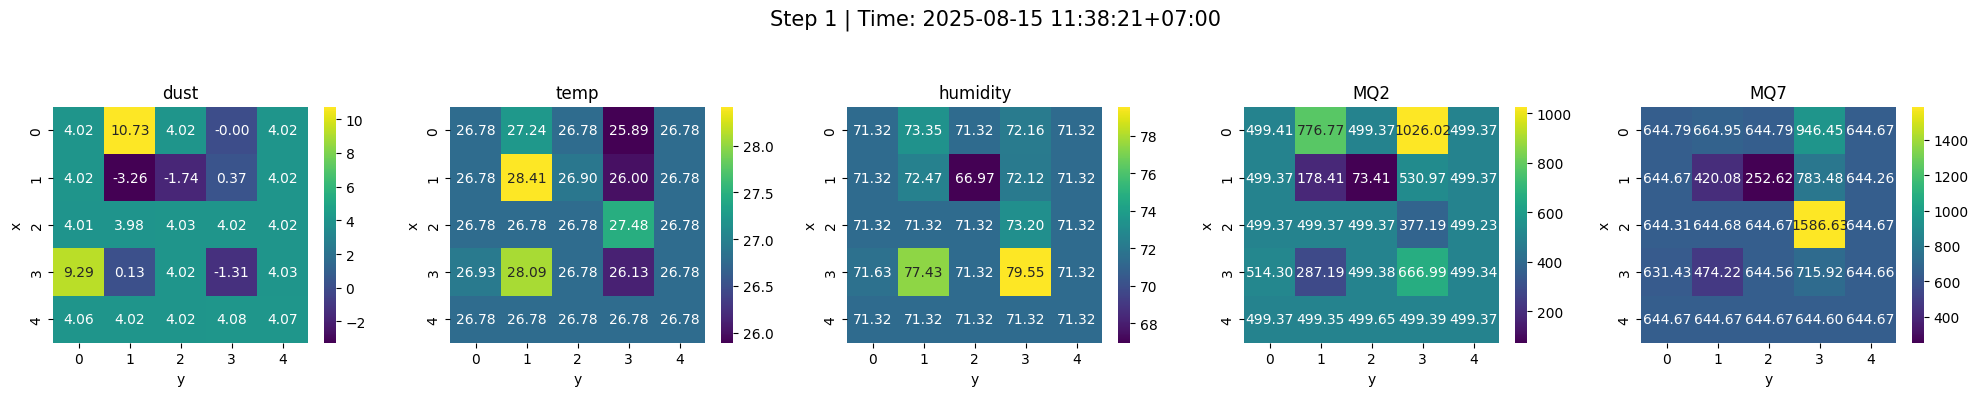

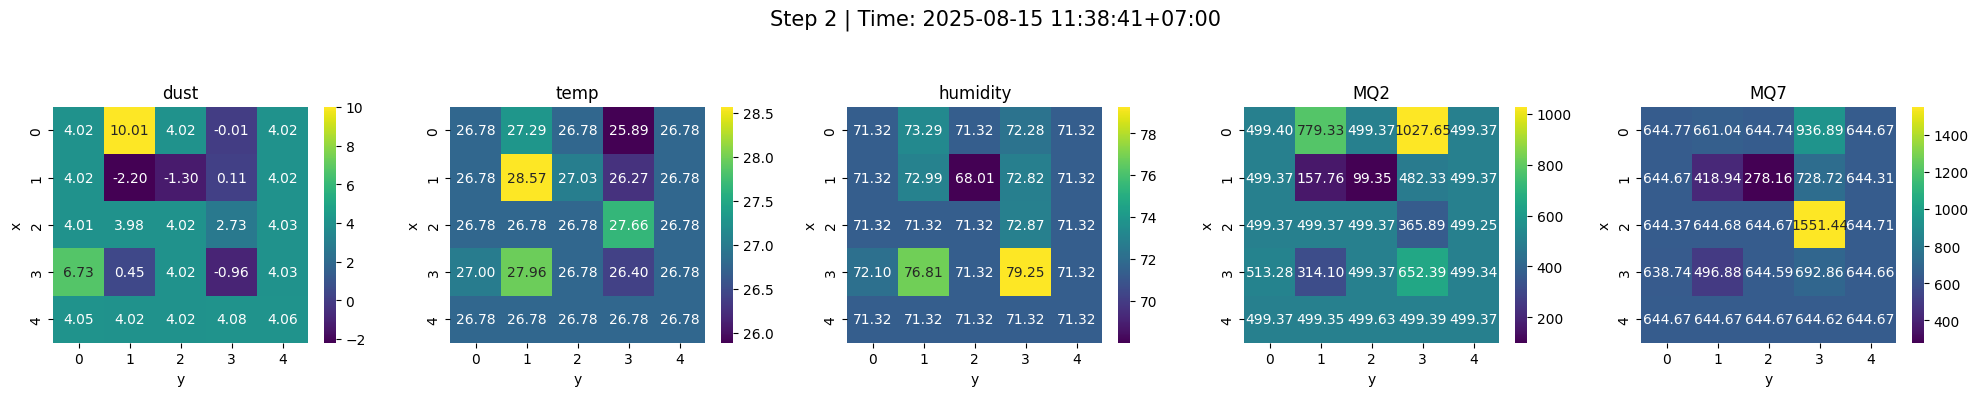

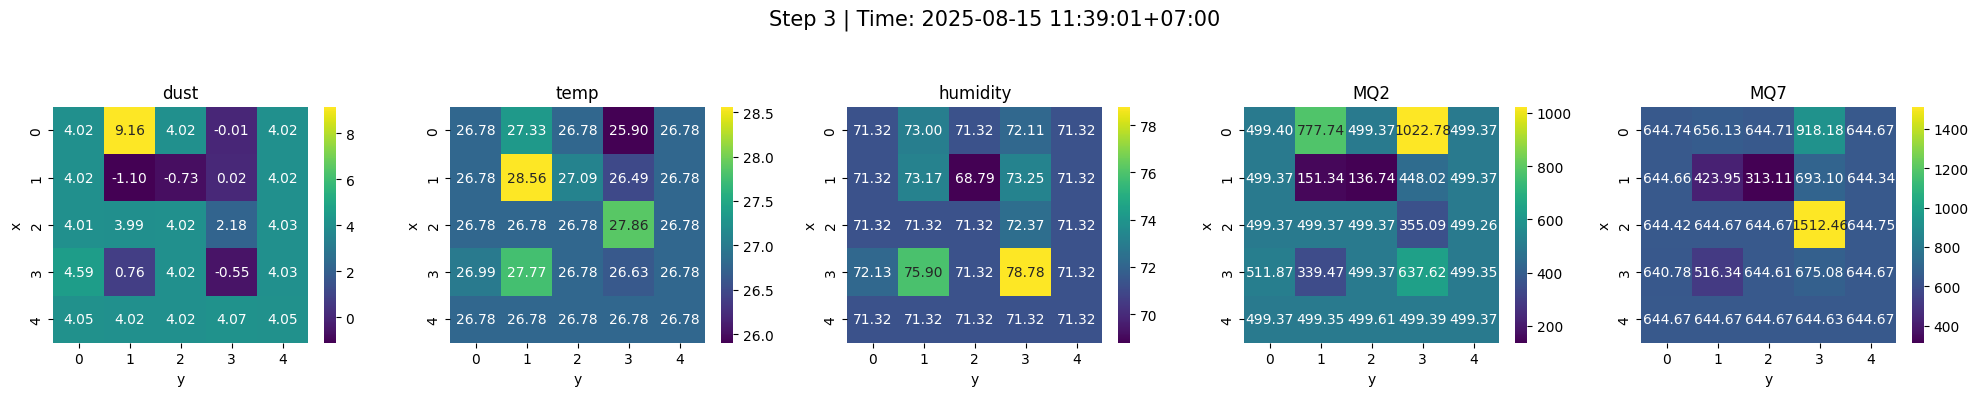

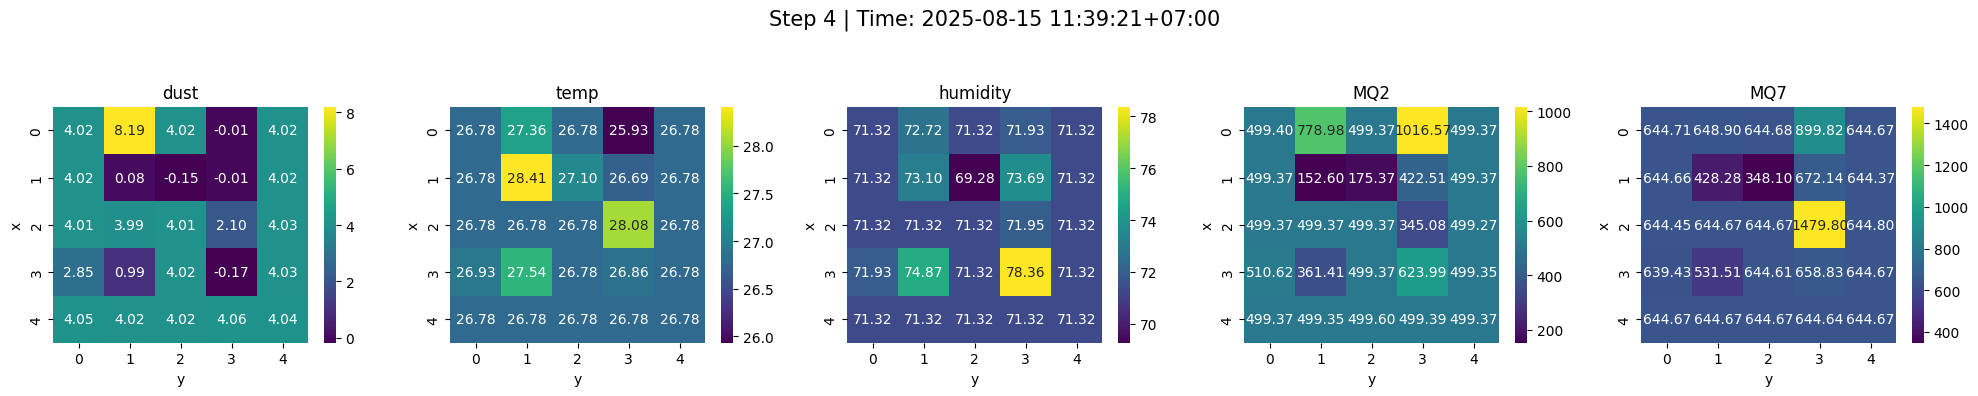

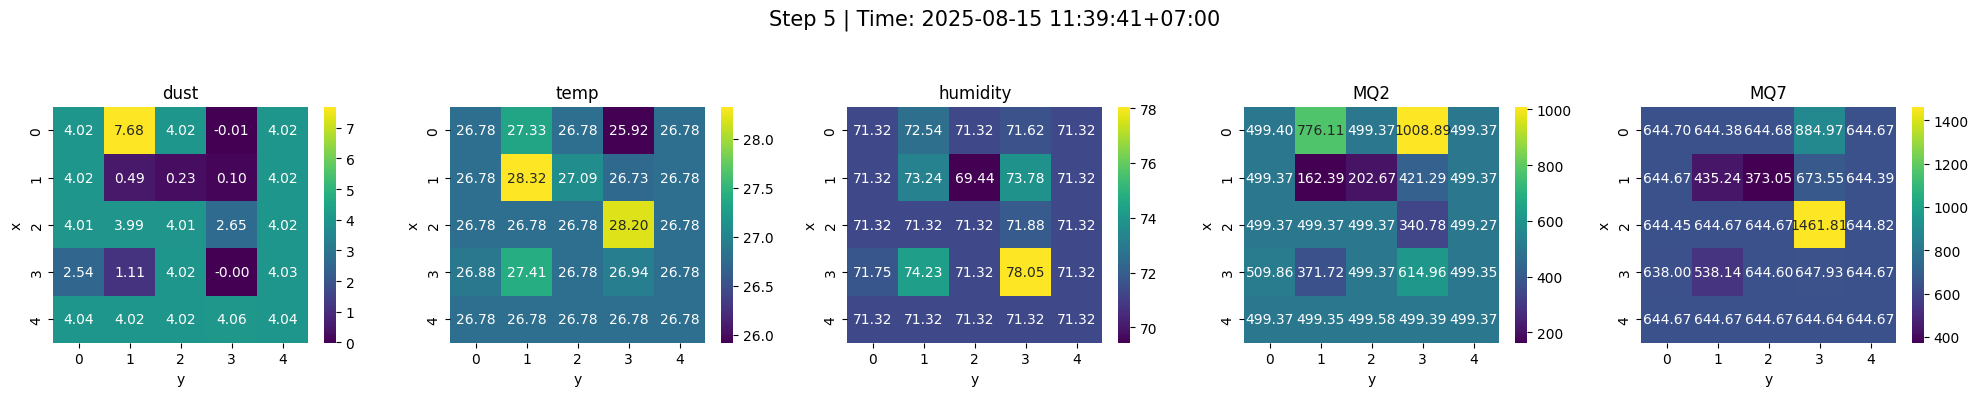

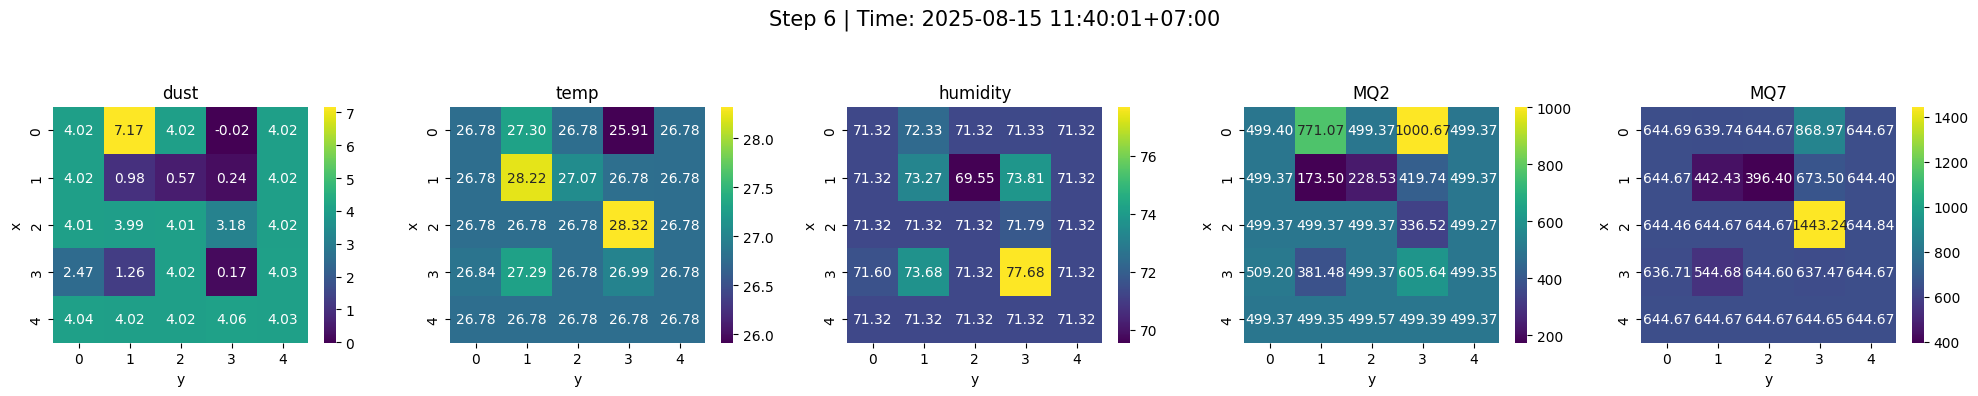

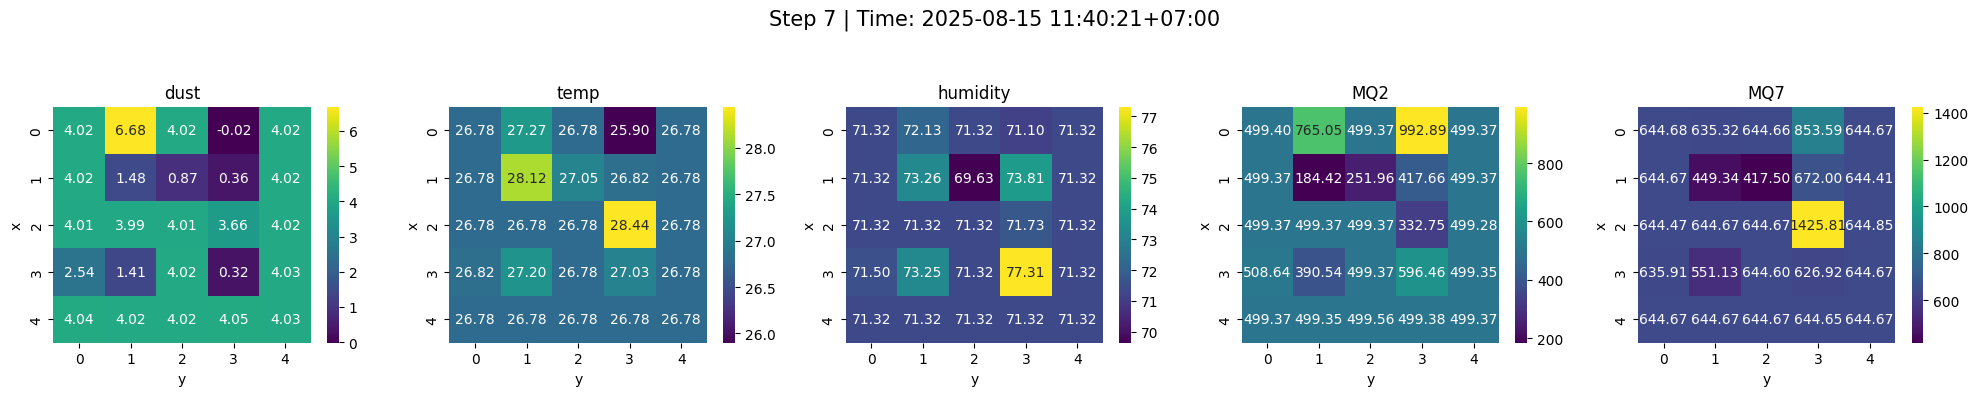

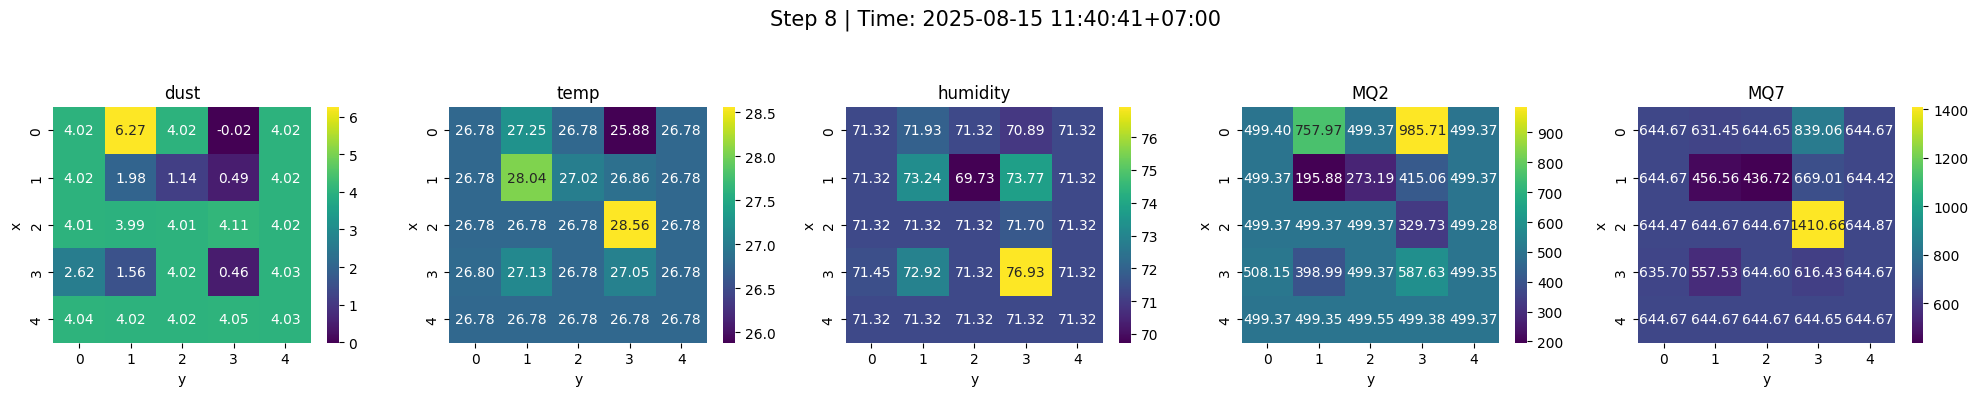

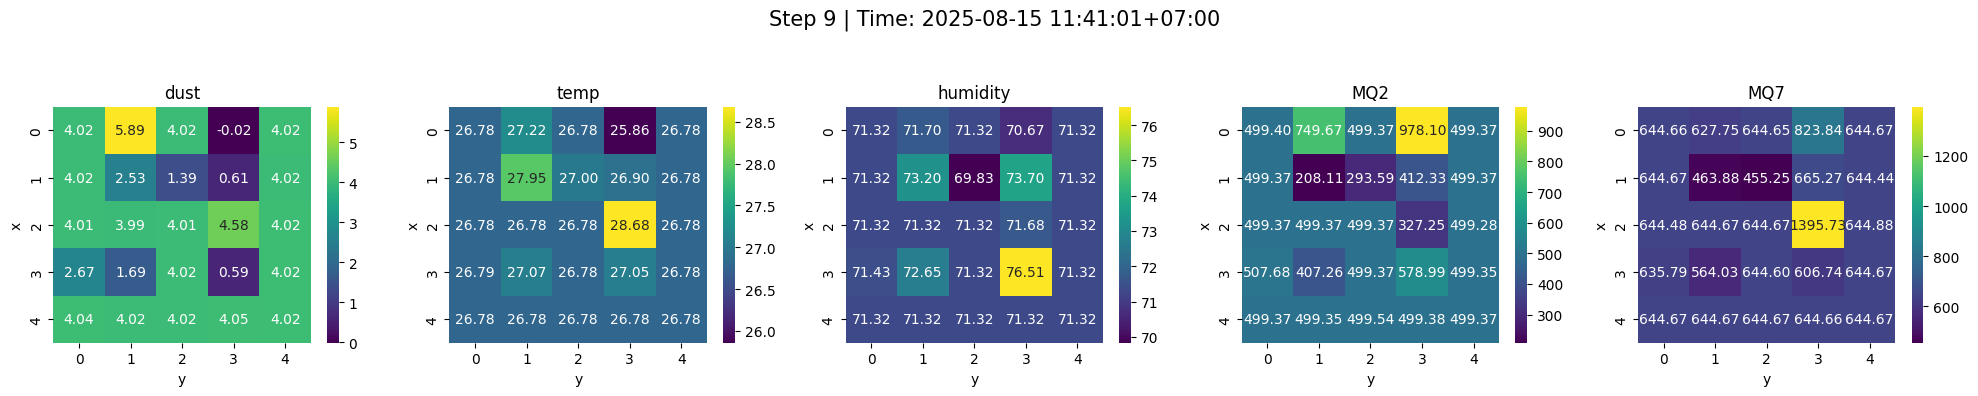

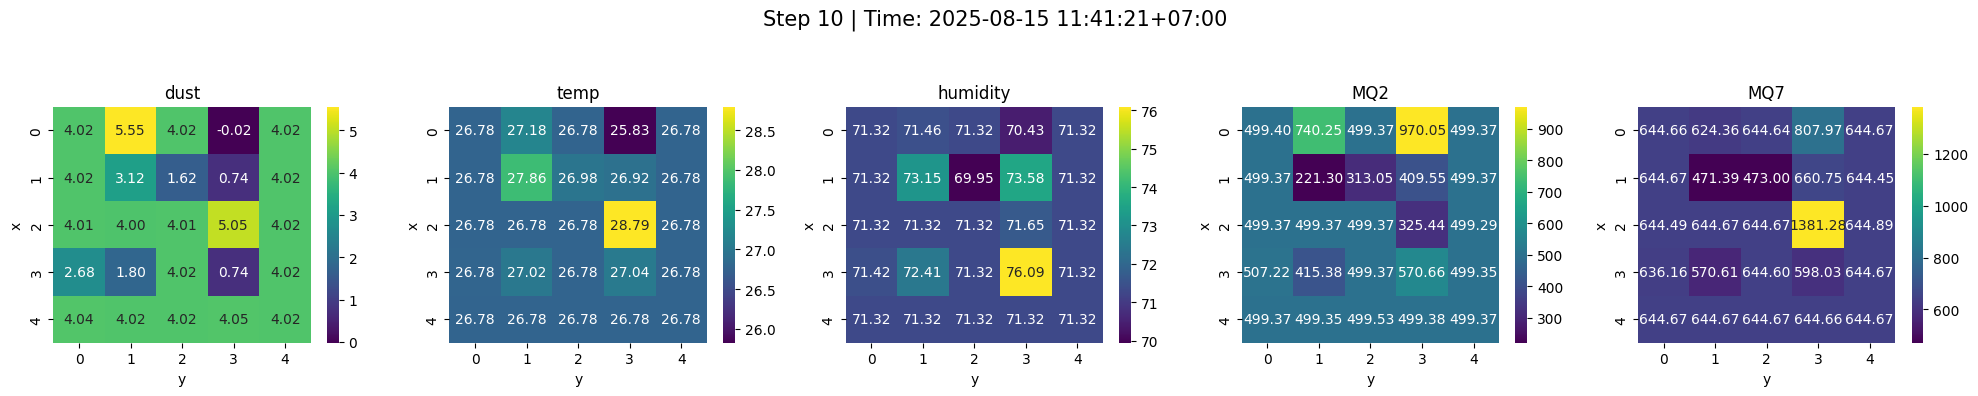

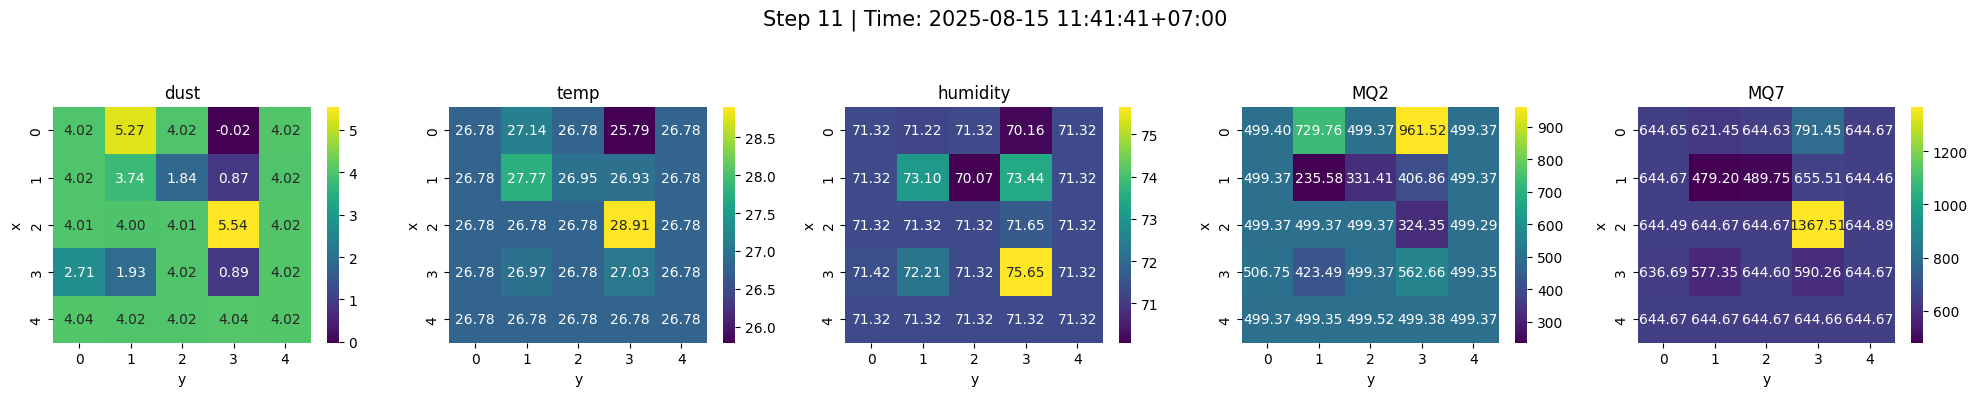

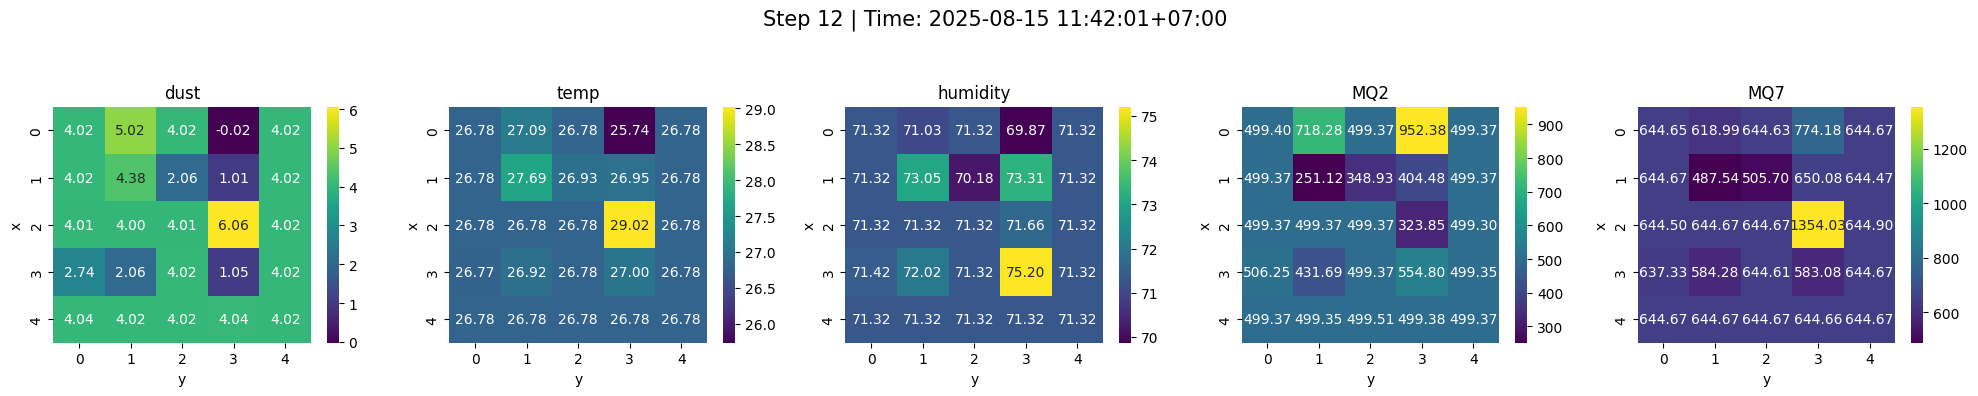

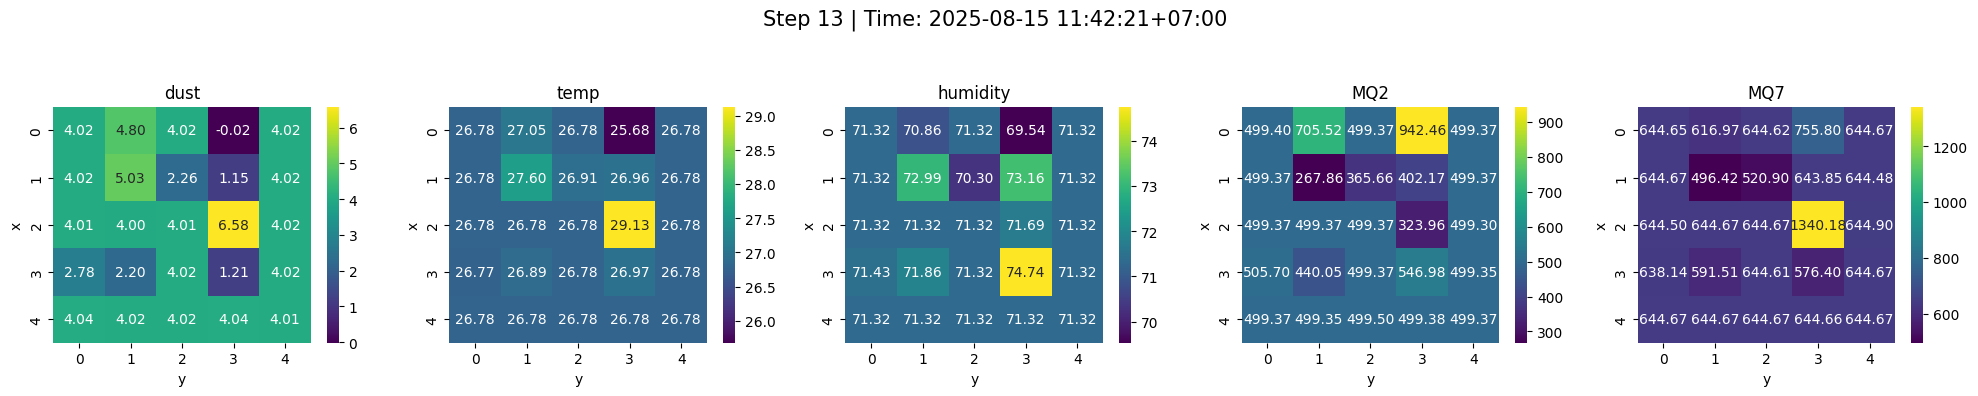

In [11]:
# Mỗi step -> 1 figure gồm 5 heatmap
for step, pred_flat in enumerate(continuous_preds_unscaled):
    snap = pred_flat.reshape(GRID, GRID, len(FEATURES))
    fig, axes = plt.subplots(1, len(FEATURES), figsize=(20, 4))
    fig.suptitle(f"Step {step+1} | Time: {prediction_times[step]}", fontsize=15)

    for fi, fname in enumerate(FEATURES):
        sns.heatmap(snap[:, :, fi], annot=True, fmt=".2f", cmap="viridis", ax=axes[fi])
        axes[fi].set_title(fname)
        axes[fi].set_xlabel("y"); axes[fi].set_ylabel("x")

    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()
